In [1]:
%matplotlib inline
import json
from pprint import pprint
Settings = json.load(open('../prototyping/settings.txt'))
pprint(Settings)
import sys
sys.path.append('../')
from keras.callbacks import ModelCheckpoint, TerminateOnNaN
from keras.models import load_models
from keras.applications.vgg16 import preprocess_input
from os.path import join, isfile, isdir, exists, splitext
import numpy as np
import matplotlib.pyplot as plt

from cabbage.data import ReId

root = Settings['data_root']
MODEL_DIR = join(root, 'models')
assert isdir(MODEL_DIR)

MODEL_TO_TEST = 'stacknet64x64_77acc.h5'
is_64 = True

model_file_name = join(MODEL_DIR, MODEL_TO_TEST)
assert isfile(model_file_name)

model = load_model(model_file_name)

if is_64:
    w, h = 64, 64
else:
    w, h = 112, 112

sampler = ReId.DataSampler(root,w,h)

{'data_root': '/home/data',
 'deepmatch': '/home/deepmatching_1.2.2_c++/deepmatching-static'}


Using TensorFlow backend.


/home/data/cuhk03_release found :)
/home/data/Market-1501-v15.09.15 found :)
/home/data/DukeMTMC-reID found :)
found memmaped /home/data/cuhk03_release/labeled64x64.npy
(cuhk) positive test pairs: 9290
(cuhk) positive train pairs: 127242
(market) positive test pairs:  300631
(market) positive train pairs:  309874
load memmap /home/data/DukeMTMC-reID/bounding_box_test64x64.npy
load memmap /home/data/DukeMTMC-reID/bounding_box_train64x64.npy
(duke) positive test pairs:  926089
(duke) positive train pairs:  749270


---------------------
	 0.78
---------------------


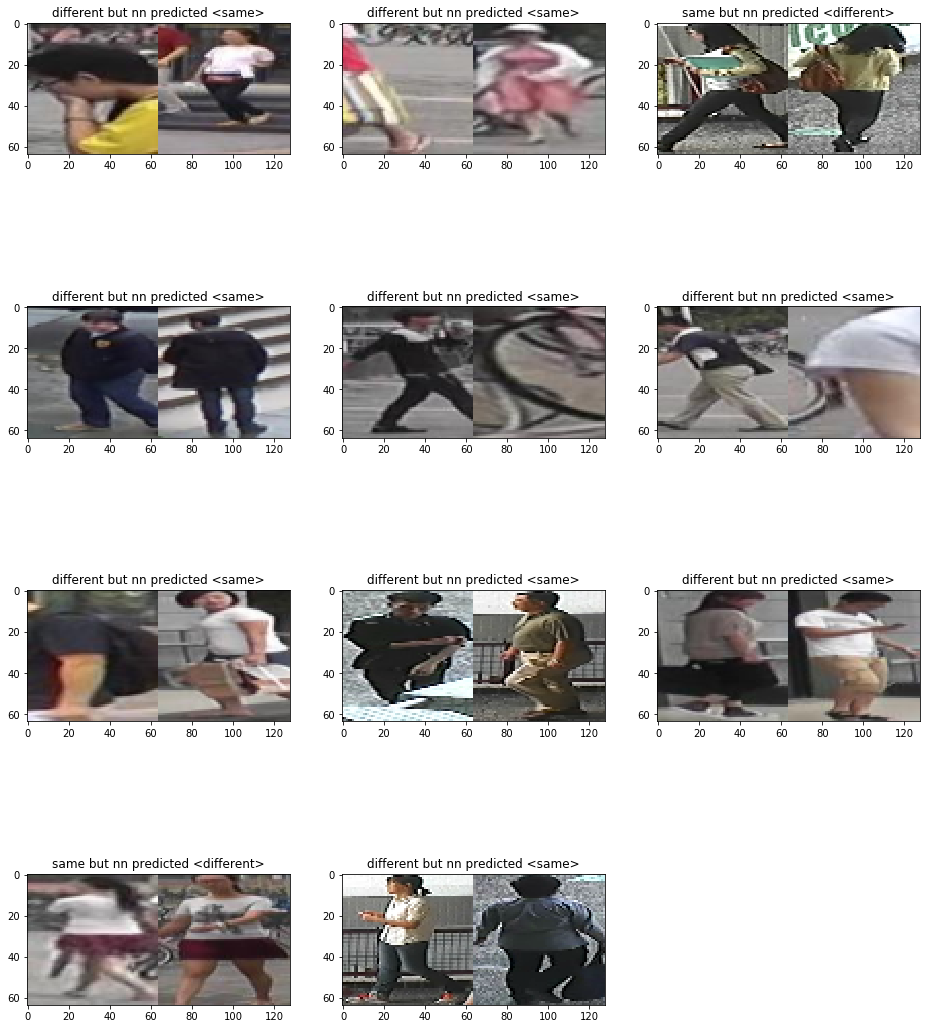

In [2]:
X, Y = sampler.get_test_batch(10, 40)
X_ = preprocess_input(X.astype('float64'))
Y_ = model.predict(X_)

Y_clipped = (Y_[:,0] > 0.5) * 1
Yclipped =  (Y[:,0] > 0.5) * 1

accuracy = np.sum( (Y_clipped == Yclipped) * 1) / len (Yclipped)

print('---------------------')
print('\t', accuracy)
print('---------------------')

fails_txt = []
fails_img = []
for i, (gt,hy) in enumerate(zip(Yclipped, Y_clipped)):
    if gt != hy:
        txt_gt = "same" if gt else "different"
        txt_hy = "<same>" if hy else "<different>"
        fails_txt.append(
            txt_gt + " but nn predicted " + txt_hy)
        fails_img.append(X[i])

fig = plt.figure(figsize=(16, 20))
n = len(fails_txt)
for i, (AB, txt) in enumerate(zip(fails_img, fails_txt)):
    ax = fig.add_subplot(int(n/3)+1, 3, i+1)
    a = AB[:,:,0:3]
    b = AB[:,:,3:6]
    x = np.concatenate([a, b], axis=1)
    ax.imshow(x)
    ax.set_title(txt)